# Extract fields from PDF text - USACE Wetland project


Last Updates: 16 September 2023


The following notebook seeks to extract the following fields, defined in the glossary.

- longitude
- latitude
- Acreage
- acre_type
- acre_term
- linear_feet
- oilgas: look in applicant name
- expiry period

It does this through three Functions:

### 1. get abstractive summaries (on entire PDF)

-    a) Run the function once for just a 3 sentence summary for dashboard use
-    b) Run the function once for a 10 sentence summary for use in next step
    
    
### 2. Run regex on text+summaries for a given column

Use pre-built regex patterns and modify as needed, to get best attempt of extracting fields from the summaries and/or the original text.

### 3. Pass text/summary to OpenAI API, and extract structured data on wetlands 


### REMAINING TO DOs:

- Convert this notebook to a .py file to start the project library and import it into the scraping scripts.

- Call these functions at the end of the scraping scripts


In [1]:
### Required libraries
# install azure

#pip install azure-core, azure-ai-ml, azure-identity, azure-ai-textanalytics

from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient
import configparser
import re
import os
import PyPDF2
import pandas as pd
import csv
import numpy as np

import openai
import re
import nltk
from nltk.tokenize import sent_tokenize
import tiktoken

from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
import json
import requests
from nltk.tokenize import sent_tokenize
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Function 2: Regex field extraction

### Create a list of regex patterns and store matches in new columns


### expiry of notice - get any phrase with 'days' if sentence has 'comment' or 'period'

### acres - 'acres'

### oil_gas - 'oil|gas|natural gas|petroleum|petrol'

### duration - 'temporary|permanent|temporarily|permanently

### wetland - 'wetland|wetlands|marsh'






## Use CSV of New Orelans


In [3]:

def regex_extraction(text: str):
    
    
    # Define your regex patterns
    exp_date_pattern = r'(?i)(?=.*(?:comment|period))(?s:.*?)(\b\d+\s+days\b)'

    acre_pattern = r'(\b\d+(\.\d+)?-?\d*\b)\s?acres?'

    wetland_pattern = r'\b(\w+\s(?:wetland|wetlands|marsh))\b'

    oilgas_pattern = r'\b(oil|gas|natural gas|petroleum|petrol)\b'

    duration_pattern = r'\b(temporary|permanent|temporarily|permanently)\b'
    
    
    # Apply patterns to extract values
    exp_periods = re.findall(exp_date_pattern, text)
    acres = re.findall(acre_pattern, text)
    oil_gas = re.findall(oilgas_pattern, text, re.IGNORECASE)
    duration = re.findall(duration_pattern, text, re.IGNORECASE)
    wetland = re.findall(wetland_pattern, text, re.IGNORECASE)

    # Create a dictionary of the extracted values
    result_dict = {
        'reg_exp_periods': exp_periods[0] if exp_periods else None,
        'reg_acres': acres[0] if acres else None,  # Converted to float
        'reg_oil_gas': oil_gas[0] if oil_gas else None,
        'reg_duration': duration[0] if duration else None,
        'reg_wetland': wetland[0] if wetland else None
    }
    
    return result_dict





## OpenAI ChatCompletion


The `ChatCompletion` object is the main interface between your requests and OpenAI, and affects your costs.



In [16]:
OPENAI_API_KEY = "sk-"

In [17]:
import requests
import json

def generate_completion(sys_prompt, input_text,  model="gpt-3.5-turbo",
                         temperature=0.7, max_tokens=150, API_KEY=OPENAI_API_KEY):
    """
    This function sends a prompt to the OpenAI API and receives a generated text completion.
    
    Parameters:
    - prompt (str): The input text prompt for the AI.
    - model (str): The model to use for the completion. Default is 'gpt-3.5-turbo'.
    - temperature (float): Controls randomness. Lower values make the model more deterministic.
    - max_tokens (int): The maximum number of tokens to generate in the completion.
    - OPENAI_API_KEY (str): Your OpenAI API key.
    
    Returns:
    - dict: A dictionary containing the completion or an error message.
    """
    url = "https://api.openai.com/v1/chat/completions"

    headers = {
        'Content-Type': 'application/json',
        'Authorization': f"Bearer {API_KEY}"
    }

    payload = json.dumps({
        "model": model,
        "messages": [{"role": "system", "content": sys_prompt}, {"role": "user", "content": input_text}],
        "temperature": temperature,
        "max_tokens": max_tokens
    })

    try:
        response = requests.post(url, headers=headers, data=payload)
        response_json = response.json()
    except Exception as e:
        return {"error": f"An error occurred: {str(e)}"}
    
    completion_json = json.dumps(response_json, indent=2)


    return completion_json


### Returns a JSON 

In [6]:
# give the input text
input_text = "Once upon a time"

# System prompt
sys_prompt = "write a Haiku"

# Generate completion
completion = generate_completion(sys_prompt, input_text, API_KEY=OPENAI_API_KEY)


print(completion)


{
  "id": "chatcmpl-91FLV0a0HdPPr69qy3ngVtUtUirJD",
  "object": "chat.completion",
  "created": 1710084345,
  "model": "gpt-3.5-turbo-0125",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "In a world of dreams and rhyme,"
      },
      "logprobs": null,
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 19,
    "completion_tokens": 8,
    "total_tokens": 27
  },
  "system_fingerprint": "fp_4f0b692a78"
}


### 1. OpenAI LLM - 1 Shot

- **Bonus** - Put 'No Yappin' at the end of the 

In [21]:
wet_text = """The applicant has proposed to discharge up to 21,710 cubic yards (CY) of commercially obtained sand and sod mix over a total area of 172,605 square feet (3.96 acres) 
within three wetlands. Up to 17,281 CY of fill would be placed in 3.24 acres of one non-tidal wetland, and up to 4,424 CY of fill would be 
placed in 0. 73 acre of two tidal wetlands. The fill would be discharged for the creation of golf course facilities, including a driving 
range tee box area, greens, and fairways."""


In [19]:
## Direct prompt - zero shot
# system prompt new

sys_prompt = """put into a dict. Only include the fields: 'latitude', 'longitude', 'linear feet', and 'wetland_impact' with subfields 'acres', 'type', and 'duration'. If information is missing, use None."

this is an example. For example, assume INPUT is:

"Locat ed in Section 20, Township 15 South, Range 20 East , in St. Charles Parish, Louisiana, (lat. 29.78860, long. -90.42970),
as shown within the attached drawings. (Hydrologic Unit Code 08 0903010302 , Des Allemands -Crawford Canal Watershed).
The proposed project is to widen the existing Crawford D rainage Canal and make improvements to the Sunset Pump Station. 
The purpose of the project is to increase the Sunset Pump Stations ability to drain the stormwater runoff that is occurring
within the Sunset Drainage District Levee polder and to increase the efficiency of the pump station. The proposed improvements
to the Sunset Pump Station are to install trash screens and cleaners upstream to the existing pump station. The project as
proposed would permanently impact approximately 2. 38 acres of waterbottoms and 0.0042 acre of wet lands from excavation and 
fill activities."

Then OUTPUT should be:


data_dict = {
    'latitude': 29.78860,
    'longitude': -90.42970,
    'endangered_species': 'spotted eagle, blue rattlesnake'
    'wetland_impact': [
        {
            'acres': 2.38,
            'type': 'waterbottoms',
            'duration': 'permanent'
        },
        {
            'acres': 0.0042,
            'type': 'wet lands',
            'duration': 'permanent'
        }
    ]
}

take a deep breath and work on this problem step by step. Don't double count the impacts. No yappin. """

### Modify the function to return the `contents` dictionary

In [22]:
import requests
import json

def generate_completion(sys_prompt, input_text, model="gpt-3.5-turbo",
                        temperature=0.7, max_tokens=150, API_KEY=OPENAI_API_KEY):
    """
    This function sends a prompt to the OpenAI API and receives a generated text completion.
    
    Parameters:
    - sys_prompt (str): The system prompt for the AI.
    - input_text (str): The user's input text for the AI.
    - model (str): The model to use for the completion. Default is 'gpt-3.5-turbo'.
    - temperature (float): Controls randomness. Lower values make the model more deterministic.
    - max_tokens (int): The maximum number of tokens to generate in the completion.
    - API_KEY (str): Your OpenAI API key.
    
    Returns:
    - str: A string containing the completion content or an error message.
    """
    url = "https://api.openai.com/v1/chat/completions"

    headers = {
        'Content-Type': 'application/json',
        'Authorization': f"Bearer {API_KEY}"
    }

    payload = json.dumps({
        "model": model,
        "messages": [{"role": "system", "content": sys_prompt}, {"role": "user", "content": input_text}],
        "temperature": temperature,
        "max_tokens": max_tokens
    })

    try:
        response = requests.post(url, headers=headers, data=payload)
        response_json = response.json()
        # Extracting the 'content' directly from the response
        content = response_json['choices'][0]['message']['content']
        return content  # Return the content directly
    except Exception as e:
        return f"An error occurred: {str(e)}"

# run the function
completion = generate_completion(sys_prompt, wet_text, model="gpt-3.5-turbo",
                        temperature=0.1, max_tokens=150, API_KEY=OPENAI_API_KEY)




In [10]:
import pprint

# Using pprint for pretty-printing the Python dictionary
pprint.pprint(completion, width=80, compact=True)

('data_dict = {\n'
 "    'latitude': None,\n"
 "    'longitude': None,\n"
 "    'linear feet': None,\n"
 "    'wetland_impact': [\n"
 '        {\n'
 "            'acres': 3.96,\n"
 "            'type': 'wetlands',\n"
 "            'duration': None\n"
 '        },\n'
 '        {\n'
 "            'acres': 3.24,\n"
 "            'type': 'non-tidal wetland',\n"
 "            'duration': None\n"
 '        },\n'
 '        {\n'
 "            'acres': 0.73,\n"
 "            'type': 'tidal wetlands',\n"
 "            'duration': None\n"
 '        }\n'
 '    ]\n'
 '}')


## 2. OpenAI Functions

### Step 1: Define OpenAI function, response schema and API call


https://platform.openai.com/docs/guides/gpt/function-calling

Under the hood, functions are injected into the system message in a syntax the model has been trained on. This means functions count against the model's context limit and are billed as input tokens. If running into context limits, we suggest limiting the number of functions or the length of documentation you provide for function parameters.

The basic sequence of steps for function calling is as follows:

Call the model with the user query and a set of functions defined in the functions parameter.
The model can choose to call a function; if so, the content will be a stringified JSON object adhering to your custom schema (note: the model may generate invalid JSON or hallucinate parameters).
Parse the string into JSON in your code, and call your function with the provided arguments if they exist.
Call the model again by appending the function response as a new message, and let the model summarize the results back to the user.

    url = "https://api.openai.com/v1/chat/completions"


In [23]:
system_prompt = """You will get a passage about a project. Use the function schema to get a dictionary. 
For each wetland, provide its type or descriptor, the area it occupies in acres,
and the duration of its impact (e.g., 'permanent' or 'temporary'). 
You should focus on sentences which contain information on area or (linear feet) and wetland type impacted.
The priority is the breakdown by wetland type. 
Only record 'impact_duration' as 'permanent' or 'temporary' if it appears in the same sentence as 'wetland_type' 
and 'area', otherwise write 'unknown'. 
DON'T exclude valid sentences.
Some passages describe multiple projects, and sequentially describe the wetland impacts for each project.            
Keywords like 'including' or 'of which' may indicate nested projects - Do not double count impacts.
The impact_type for a wetland is usually loss or damage. 
Sometimes words like positive, beneficial, restoration etc. will indicate a positive or neutral impact, record it.
Take a deep breath, and work on this problem step-by-step. Here is the text: """ 

In [24]:
GPT_MODEL = "gpt-3.5-turbo-0613"



#### ChatCompletion request

In [45]:
#@retry(wait=wait_random_exponential(multiplier=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, functions=None, function_call=None, model=GPT_MODEL):
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + OPENAI_API_KEY,
    }
    json_data = {"model": model, "messages": messages, "temperature": 0}
    if functions is not None:
        json_data.update({"functions": functions})
    if function_call is not None:
        json_data.update({"function_call": function_call})
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e


#### Define Function Schema

In [46]:

### Function 1 - Wetland impact

main_func = [

            { # function to capture wetland impacts
              "name": "wetland_analysis",
              "description": """Get attributes for project, wetlands, area and duration.""",
              "parameters": {
                "type": "object",
                "properties": {
                   "wetlands": {
                    "type": "array",
                    "description": "Array containing information about project and impact on wetlands etc..",
                    "items": {
                      "type": "object",
                      "properties": {
                        "wetland_type": {
                          "type": "string",
                          "description": "The type or descriptor of the wetland, waters, waterbottoms, swamp, marsh etc."
                        },

                          "impact_quantity": {
                          "type": "string",
                          "description": "The quantity of the wetland, stream or land impacted. Only numeric."
                        },
                          
                        "impact_unit": {
                          "type": "string",
                          "enum": ["acres", "sq. feet", "linear feet"],
                          "description": "The units of the measurement for the impacted area of the wetland. Only text."
                        },

                        "impact_duration": {
                          "type": "string",
                          "enum": ["permanent", "temporary", "unknown"],
                          "description": "Duration of impact or loss of the wetland, e.g., 'permanent' or 'temporary'. Write 'Unknown' if no descriptor in same sentence."
                        },
                        "impact_type": {
                          "type": "string",
                          "description": "Whether project impact is harmful, beneficial or unknown. "
                        }
                          
                      }
                    }
                  }
                }
              }
            }

        ]



## Call the Completion with the function schema

In [53]:

def openAIfunc_wetland(input_text):
    messages = []
   # messages.append({"role": "system", "content": "Work step by step."})   # POTENTIAL ERROR
    messages.append({"role": "user", "content": system_prompt  + input_text                
                    })

# https://arxiv.org/pdf/2309.03409.pdf
    chat_response = chat_completion_request(
        messages, functions=main_func, function_call={"name": "wetland_analysis"}
    )

    func_response = chat_response.json()["choices"][0]["message"]["function_call"]["arguments"]

    # Convert the stringified JSON to a Python dictionary
    func_response_dict = json.loads(func_response)

    # except (KeyError, json.JSONDecodeError) as e:
    # print(f"An error occurred: {e}")
    # func_response_dict = {}

    return func_response_dict


### Convert to a flat structure (explode into rows)

In [55]:
aa = openAIfunc_wetland(wet_text)

# Convert the 'wetlands' list of dictionaries to a DataFrame
# pd.DataFrame(aa['wetlands'])
aa

{'wetlands': [{'wetland_type': 'non-tidal wetland',
   'impact_quantity': '3.24',
   'impact_unit': 'acres',
   'impact_duration': 'unknown',
   'impact_type': 'loss'},
  {'wetland_type': 'tidal wetland',
   'impact_quantity': '0.73',
   'impact_unit': 'acre',
   'impact_duration': 'unknown',
   'impact_type': 'loss'}]}

## Run the above workflow on all notices


We are now ready to run this on our entire dataset of notice texts. Call the `openAIfunc_wetland` function in a vectorized manner use the `pd.apply` on the `pdf_character` column.

This gives us a column containing the JSON as a string.

In [20]:
df = pd.read_parquet(r'data\val_df_5jan.parquet')

#get a sample of 10 notices
df = df[df.wetland_llm_dict.notna()][['noticeID', 'pdf_character']].sample(5)

#Call the function
df['wetland_llm_dict'] = df['pdf_character'].apply(lambda x: openAIfunc_wetland(x))

#df.to_csv('new_orleans_160_parsed.csv')
df

,noticeID,pdf_character,wetland_llm_dict
1434,Notice_NO_2877,Conduct clearing and grading operations and pl...,{'wetlands': [{'wetland_type': 'jurisdictional...
2761,Notice_NO_3705,The MPC proposes to construct an access road a...,"{'wetlands': [{'wetland_type': 'pine savanna',..."
739,Notice_NO_2171,The applicant has requested a Department of th...,{'wetlands': [{'wetland_type': 'back barrier m...
4092,Notice_NO_3967,This proposed work is a re vision to the previ...,{'wetlands': [{'wetland_type': 'palustrine for...
5101,Notice_NO_5793,The applicant seeks authorization to remove an...,"{'wetlands': [{'wetland_type': 'unknown', 'are..."


## Function 3 Step 2: JSON ---> Dictionary --> Columns

In [21]:

from typing import List

def json_to_columns(df_source: pd.DataFrame, dict_col: str, index_col: str) -> pd.DataFrame:
    """
    Processes a DataFrame to extract information into a new DataFrame.

    Parameters:
    - df_source (pd.DataFrame): The source DataFrame containing the data.
    - dict_col (str): The column name in df_source that contains dictionaries.
    - index_col (str): The column name in df_source containing the index or ID you wish to record.
    
    Returns:
    - pd.DataFrame: A new DataFrame with extracted information.
    """
    # Initialize an empty DataFrame to store the final data
    df_main = pd.DataFrame()
    
    # Loop through each row in the source DataFrame
    for _, row in df_source.iterrows():
        # Extract the function response dictionary and index for each row
        func_response_dict = row[dict_col]
        row_index = row[index_col]
        
        # Create a temporary DataFrame for non-wetland data
        df_temp = pd.DataFrame({
            'index': [row_index],
            'latitude': [func_response_dict.get('latitude', np.nan)],
            'longitude': [func_response_dict.get('longitude', np.nan)]
        })

        # Create a DataFrame for the wetlands data
        wetlands_df = pd.DataFrame(func_response_dict.get('wetlands', []))

        # Handle the case where no wetlands data is present
        if wetlands_df.empty:
            wetlands_df = pd.DataFrame(columns=['wetland_type', 'acres', 'impact_duration'])
            wetlands_df.loc[0] = [np.nan, np.nan, np.nan]

        # Duplicate the temporary DataFrame to have the same number of rows as wetlands_df
        df_temp = pd.concat([df_temp] * len(wetlands_df), ignore_index=True)

        # Combine the two DataFrames
        df_combined = pd.concat([df_temp, wetlands_df], axis=1)

        # Append to the main DataFrame
        df_main = pd.concat([df_main, df_combined], ignore_index=True)

    return df_main


In [23]:
new_df = json_to_columns(df_source=df, dict_col='wetland_llm_dict', index_col='noticeID')
new_df

,index,latitude,longitude,wetland_type,area,impact_duration,impact_type
0,Notice_NO_2877,NaN,NaN,jurisdictional pine-hardwood flatwoods,2.8 acres,permanent,loss
1,Notice_NO_3705,NaN,NaN,pine savanna,2.8 acres,unknown,loss
2,Notice_NO_2171,NaN,NaN,back barrier marsh,unknown,unknown,restoration
3,Notice_NO_2171,NaN,NaN,marsh,1061 acres,unknown,creation
4,Notice_NO_2171,NaN,NaN,waterbottoms,404 acres,unknown,dredging
5,Notice_NO_3967,NaN,NaN,palustrine forested wetlands,6.24 acres,unknown,loss
6,Notice_NO_3967,NaN,NaN,mixed forested wetlands,unknown,unknown,loss
7,Notice_NO_5793,NaN,NaN,unknown,497 square feet,unknown,unknown
8,Notice_NO_5793,NaN,NaN,unknown,"4,996 square feet",unknown,unknown


## Metrics and evaluation


In [59]:
df = pd.read_csv(r'data\all_finetune_samples_6march.csv')

# take 60
df  = df.head(60)

df['wetland_llm_dict'] = df['assistant'].apply(lambda x: openAIfunc_wetland(x))

df.head()


,Unnamed: 0,noticeID,user,assistant,wetland_llm_dict
0,729,Notice_NO_2161,To excavate and install and maintain fill to c...,{'wetlands': [{'wetland_type': 'other waters o...,{'wetlands': [{'wetland_type': 'other waters o...
1,802,Notice_NO_2234,"To clear, grade, excavate, and install and mai...",{'wetlands': [{'wetland_type': 'forested wetla...,{'wetlands': [{'wetland_type': 'forested wetla...
2,837,Notice_NO_2270,The applicant i s requesting aDepartment ofthe...,{'wetlands': [{'wetland_type': 'forested wetla...,{'wetlands': [{'wetland_type': 'forested wetla...
3,890,Notice_NO_2323,The applicant has requested Department of the ...,{'wetlands': [{'wetland_type': 'forested wetla...,{'wetlands': [{'wetland_type': 'forested wetla...
4,1103,Notice_NO_2541,The proposed bank property totals approximatel...,{'wetlands': [{'wetland_type': 'bottomland har...,{'wetlands': [{'wetland_type': 'bottomland har...


In [63]:
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

# Assuming 'df' is your DataFrame.

# Prepare the dataset for evaluation
# Assuming that the JSON strings are directly in the 'assistant' and 'wetland_llm_dict' columns.
reference_outputs = df['assistant'].astype(str).tolist()
model_outputs = df['wetland_llm_dict'].astype(str).tolist()

# Tokenize the reference and model output strings for METEOR score calculation
reference_outputs_tokenized = [word_tokenize(ref) for ref in reference_outputs]
model_outputs_tokenized = [word_tokenize(out) for out in model_outputs]

# Calculate METEOR Score for each pair and assign as a new column
df['meteor_score'] = [meteor_score([ref], out) for ref, out in zip(reference_outputs_tokenized, model_outputs_tokenized)]

# Calculate BLEU Score for each pair and assign as a new column
df['bleu_score'] = [sentence_bleu([ref], out) for ref, out in zip(reference_outputs_tokenized, model_outputs_tokenized)]

# Display the DataFrame with the new columns
df[['meteor_score', 'bleu_score']].mean()

meteor_score    0.999303
bleu_score      0.997755
dtype: float64

## Error ?!


"The applicant states t hat the site includes **0.02 acre of saltwater marsh area** (FLUCCS \n642) along the south side of the lot, along Prescott Street, **0.21 acre of mangrove \nswamps** (with some exotic infestation) (F LUCCS 612) in the middle, and 0.06 acre of \nopen water (FLUCCS 540) to the north. 

PROPOSED WORK: The applicant seeks author ization to construct a single-family \nresidence on the 0.29-acre parcel, including the **permanent fill and loss of 0.12 acre of \nestuarine marsh and mangrove wetlands** asso ciated with the lot fill, driveway, and \nretaining wall, and the construction of a 4-foot-wide by 119-f oot-long private dock and \naccessway with an 8-foot-wide by 20-foot-long terminal platform, a nd two (2) vertical \nboatlifts (12-foot by 20-foot boatlift and  15-foot by 30-foot boatlift).

---

0.12 acre of 'estuarine marsh and mangrove wetlands'. here 'estuarine' was assigned to wetland 1. 

Wetland 2 wa mangrove, but the area assigned was 0.21 acre . It is a bit ambiguous if all the wetlands in the site would be affected. But it didn't include 0.02 acre of saltwater marsh area. 

**But it missed the duration - 'permanent fill and loss'**. Regex would have caught it. Can think of having a 'round 2' on the known mismatches.

## Alter prompt for long passages

- Chain of thought (CoT)

- Step by step, show your work.


https://wandb.ai/jxnlco/function-calls/reports/Better-Data-Extraction-Using-Pydantic-and-OpenAI-Function-Calls--Vmlldzo0ODU4OTA3


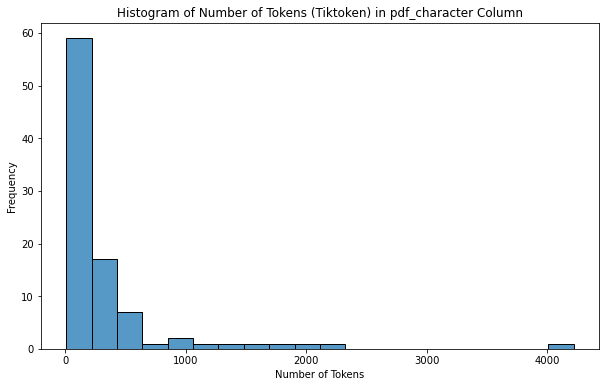

### Relation between tokens and response time

In [146]:
import time
func_times = []

# Function to apply on each row and record time
def timed_openAIExtractionFunction(x):
    start_time = time.time()
    response = openAIExtractionFunction(x)
    end_time = time.time()
    elapsed_time = end_time - start_time
    func_times.append(elapsed_time)
    return response

# Apply the function and store the response
dfm['llm_response_dict'] = dfm['pdf_character'].apply(timed_openAIExtractionFunction)

# Add the function times as a new column
dfm['func_time'] = func_times


<AxesSubplot:xlabel='token_count', ylabel='func_time'>

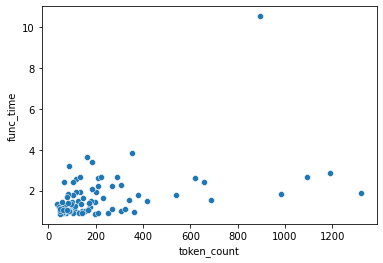

In [149]:
sns.scatterplot(data=dfm, x="token_count", y="func_time")

## Chunking

In [ ]:
def extract_numerical_value(acres_str):
    try:
        return float(acres_str.split()[0])
    except (AttributeError, ValueError, IndexError, TypeError):
        return None  # Replace with any default value if you prefer

# Create a new column with the numerical values
final_df2['area_num'] = final_df2['area'].apply(extract_numerical_value)


In [42]:

def split_text_into_chunks(text, max_tokens=500):
    words = text.split(' ')
    chunks = []
    current_chunk = []
    current_length = 0
    
    for word in words:
        if current_length + len(word) <= max_tokens:
            current_length += len(word) + 1  # +1 for the space
            current_chunk.append(word)
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_length = len(word)
            
    chunks.append(' '.join(current_chunk))  # Append the last chunk
    return chunks


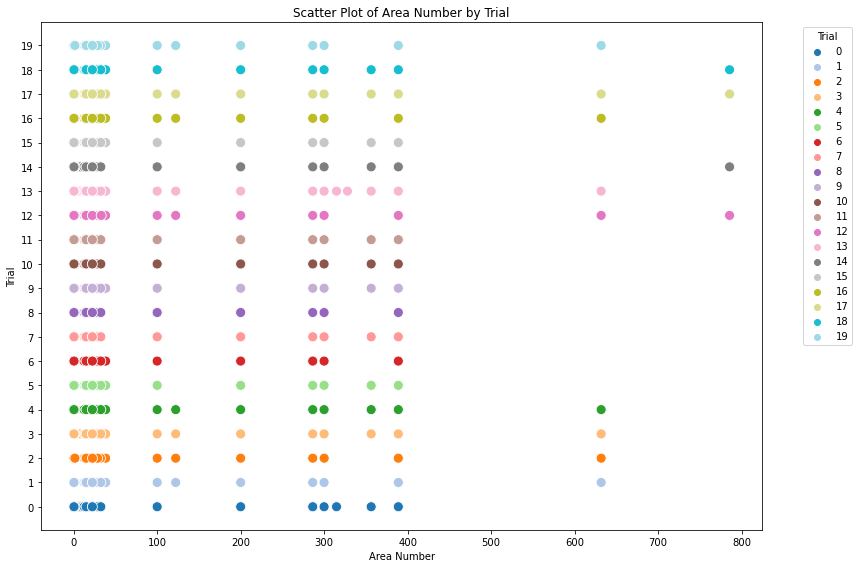

In [296]:

all_data = []
final_dataframes = []

for trial in range(20):
    text = jack2#df_val.pdf_character[(df_val.token_count==1192)].values[0] # Replace this with the actual text for each trial
    chunks = split_text_into_chunks(text)
    
    trial_data = []
    for chunk in chunks:
        data = openAIfunctemplate(chunk)  # Replace 'openAIfunctemplate' with your actual function
        trial_data.append(data)
        
    all_data.append(trial_data)  # This list now contains data for each chunk in each trial
    
    # Convert to DataFrames and concatenate
    trial_dataframes = [pd.DataFrame(data['wetlands']) for data in trial_data]
    trial_final_df = pd.concat(trial_dataframes, keys=[trial]*len(trial_data), names=['trial'])
    final_dataframes.append(trial_final_df)

# Concatenate all trial DataFrames
final_df2 = pd.concat(final_dataframes)

# Set the figure size
plt.figure(figsize=(12, 8))

# Create the scatter plot
sns.scatterplot(data=final_df2, y='trial', x='area_num', hue='trial', palette='tab20', s=100, marker='o')

# Make y-axis discrete
plt.yticks(final_df2['trial'].unique())

# Customize plot appearance
plt.xlabel('Area Number')
plt.ylabel('Trial')
plt.title('Scatter Plot of Area Number by Trial')
plt.legend(title='Trial', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()
#final_df2.to_csv(r'D:\llm_results_jack2_chunk.csv')

In [45]:
# metric - information + reliability (variance across batches) - threshold above which hand-coded.

# any pattern in why its missing?
jack2 = """
To construct and operate ( 1) natural gas liquefaction, storage, and export facilities at a Liquefied natural gas (LNG) 
terminal (Terminal Facilities) near the mouth of the Calcasieu Ship Channel in Cameron Parish, Louisiana; and ( 2) associated 
pipeline facilities connecting the Term inal Facilities to the existing natural gas pipeline grid in east Texas and southwest
Louisiana (Pipeline System).  The 2  Terminal Facilities consist of the mainland Terminal Site east of the ship channel and 
the Marine Facilities on Monkey Island.  LNG transfer and utility lines will run underground between the Terminal Site and 
the Marine Facilities.   The attached tables summarize the  impacts on wetlands and other waters of the U.S. associated with 
the proposed Terminal Facilities and Pipeline System, and as further described below.   CP2 LNG Terminal Facilities  
The Terminal Facilities will be constructed on 785.5 acres.  Five existing storage yards (including four marine yards on 
Calcasieu Pass) close to the Terminal Facilities will support construction.  These yards comprise an additional 38.3 acres. 
The Terminal Site will affect 631.7 acres and will include pretreatment, liquefaction, power generation, storage, and support 
facilities. The Marine Facilities will occupy 122.2 acres on the southwest shorel ine of Monkey Island, which is located
between the Calcasieu Ship Channel and Calcasieu Pass.  The Marine Facilities will include two LNG carrier loading docks, 
an excavated/dredged berthing area, and land- based support facilities.  Three 1.0- mile-long, 42- inch outside diameter 
LNG transfer pipelines, a boil -off gas pipeline, and associated utilities will run underground within a 31.6- acre temporary 
construction corridor between the Terminal Site and Marine Facilities.   At the Terminal Site, approximately 327.9 acres of
wetlands will be impacted, including 286.3 acres of palustrine emergent (PEM) wetland, 32.1 acres of palustrine scrub- shrub 
(PSS) wetland, 1.7 acres of palustrine forested (PFO) wetland, and 7.8 acres of estuarine intertidal emergent (E2EM) wetland 
(also categorized as essential fish habitat [EFH]).  Of the 327.9 impacted wetland acres, 314.8 acres will be permanently
impacted, 0.7 acre will be subject to extended temporary impacts (lasting for the full dur ation of Project construction), 
and 12.4 acres will be subject to short -term temporary impacts.  Approximately 4.2 acres of open waters will be permanently
impacted and 1.0 acre will be temporarily impacted.    At the Marine Facilities on Monkey Island, approximately 41.2 acres of
wetlands will be permanently impacted, including 13.8 acres of PEM wetland, 12.6 acres of PSS wetland, 0.6 acre of PFO wetland,
and 14.2 acres of E2EM wetland.  Of the 14.2 acres of E2EM wetland, 12.5 shoreline acres within the dr edge prism will be 
converted to open water and 1.7 acres will be permanently filled for onshore facility construction.  The E2EM wetland is 
categorized as EFH, along with 19.4 acres of tidal waters within the dredge prism, the 0.3 acre of land- based open w aters
that will be permanently removed, and the 0.2 acre of land- based open waters that will be converted to deep water.   
During construction, a temporary 6.8- mile-long pipeline will transport dredged material from the Marine Facilities to a 
marsh creation/restoration site located at Cameron Prairie National Wildlife Refuge (CPNWR). The pipeline will temporarily 
impact approximately 15.0 acres of PEM wetlands and 0.1 acre of PSS wetlands.      3  Pipeline System   CP Express will 
construct approximately 85.4 m iles of 48- inch-diameter underground natural gas pipeline (CP Express Pipeline), 6.0 miles of 
24- inch-diameter underground lateral pipeline (Enable Gulf Run Lateral), and associated aboveground facilities, all in Texas and Louisiana.  
Facilities located wi thin the USACE -New Orleans District will be constructed on approximately 1,339.4 acres of land and include 58.5 miles
 of the CP Express Pipeline, most of the 6.0- mile-long Enable Gulf Run Lateral, one compressor station (Moss Lake Compressor Station), 
 two standalone mainline valves, three standalone meter stations, and permanent access roads.  Construction of the Pipeline  System will 
 be supported by four temporary storage yards, all in Calcasieu Parish, and temporary access roads.   The Pipeline System will impact
approximately 741.8 acres of wetlands, including 388.8 acres of PEM wetland, 28.7 acres of PSS wetlands, 22.5 acres of PFO wetlands, 
299.9 acres of E2EM wetlands, 0.4 acre of estuarine intertidal scrub-shrub ( E2SS) wetlands,  and 1.5 acres of palustrine aquatic bed 
(PAB) wetlands.  Approximately 33.0 acres of wetlands will be permanently lost (32.5 acres of PEM wetlands, 0.1 acre of PFO wetlands,
and 0.4 acre of E2EM wetlands).  In addition, 22.4 acres of PFO wetlands will be converted to another wetland type.  Most wetlands 
on the Pipeline System will be only temporarily impacted, including 356.3 acres of"""


### Notes

##### **assumption** - the most critical information is in sentences like 'X acres of ABC wetlands', must contain both area and type.

MODE - run it 5 times, within certain amount of disagreement - kick off to manual review


Summary and metrics - we do not guaranttee accuracy.

run it 4 times - 3 that agree - take average - run multiple times


extractive summary - sample of 10 you can physically check yourself


---------------------------------------------------------------------

wetland type - is more important


each line is a text summary of the impact - 

----------------------------------------------------------------------

ALTERED data model - for same notices LLM and Regex


What percent are errors, edge cases - what regex vs llm is pulling

Use regex, to find if in this text, how many sentences have permanently BUT NOT wetland

In [37]:


def sent_regex_extraction(text: str):
    acre_pattern = r'(\b\d+(\.\d+)?-?\d*\b\s?acre?s?)'
    wetland_pattern = r'\b(\w+\s(?:wetland?s?|marsh|waterbottom|water?s?))\b'

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # Initialize list to store combined matches for each sentence
    combined_list = []

    # Loop through each sentence to find matches
    for sentence in sentences:
        combined_matches = []
        
        acres = [match[0] for match in re.findall(acre_pattern, sentence)]
        wetland = [match for match in re.findall(wetland_pattern, sentence, re.IGNORECASE)]

        # Combine the matches
        combined_matches.extend(acres)
        combined_matches.extend(wetland)

        # Append to list if matches are found
        if combined_matches:
            combined_list.append(combined_matches)

    return combined_list


## Method 2: Langchain + Output Parser  - Extraction

https://python.langchain.com/docs/use_cases/extraction

- OpenAI functions

https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/chains/openai_functions/extraction.py


- Output parsing

https://python.langchain.com/docs/modules/model_io/output_parsers/

Also try daVinci, 

https://colab.research.google.com/github/langchain-ai/langchain/blob/master/docs/extras/use_cases/extraction.ipynb


So, Two options:

- 1. OpenAI functions: can ask for things not explictly enumerated in the schema

 Its sort of strange, it'll take all its understanding from what is implicit in the schema and the field names. so **impact_type** is not good enough - it'll sort of summarize ('excavation and fill activities'). But **impact_duration** mostly works.
 
 

- 2. Output parser